In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
from pyro import distributions as dist
from pyro.infer.predictive import Predictive, _guess_max_plate_nesting
import sys
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_sample
import operator
sys.path.append("..")
sys.path.append("../ppca")
pyro.enable_validation(True) 

from tracepredictive import *
from inference import *
from initializations import *
from models_and_guides import *
from plotting import *
from utils import *

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# set seed to generate the same dataset every time
seed = 45
pyro.set_rng_seed(seed)

In [4]:
D = 10
N = 5000
K = 4

In [5]:
config = dict(
    n_iter = 1000,
    learning_rate = 0.1,
    beta1 = 0.9,
    beta2 = 0.999,
    learning_rate_decay = 0.9999,
    batch_size = 16,
    n_elbo_particles = 16,
    n_posterior_samples = 512,
    window = 10,
    convergence_window = 15,
    slope_significance = 1,#0.1,
    track_params = True,
    monitor_gradients = True,
    telemetry = None,
)

In [6]:
zeroMeanFactor_teacher = ZeroMeanFactor(torch.empty(N,D), K, N, '0')

In [7]:
dgp = zeroMeanFactor_teacher.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()

In [8]:
true_variables.keys()

dict_keys(['D_0', 'cov_diag_0', 'K_0', 'cov_factor_0', 'N_0', 'obs'])

In [9]:
true_variables['cov_diag_0'], true_variables['cov_factor_0']

(tensor([2.6795e+00, 6.6177e-01, 2.4239e-01, 1.5909e+00, 1.0316e+00, 1.8613e+02,
         3.7418e-01, 1.9098e+00, 1.3952e-01, 2.8552e+00], grad_fn=<ExpBackward>),
 tensor([[ 0.9074, -0.7569, -0.2540, -1.2867, -0.2392, -0.3749,  0.9142,  1.6347,
           0.8301, -0.5678],
         [ 1.0920,  0.3453, -0.0385,  0.5402,  0.0815, -0.0193,  1.9330, -2.0075,
           1.4745,  0.2667],
         [ 0.3857, -2.5049,  0.6552, -0.5223, -0.0759,  0.7327,  0.8501, -1.9583,
           1.9228,  1.5177],
         [ 0.0851, -0.2767,  0.3996,  1.8891,  1.2374,  0.1797, -0.7443,  1.2833,
           3.0424,  0.8803]], grad_fn=<AddBackward0>))

In [10]:
#random_dims = np.random.choice(D, size=2)
#plt.scatter(*X[:,random_dims].T,alpha=.2)
#plt.xlabel(f'Dim {random_dims[0]}')
#plt.ylabel(f'Dim {random_dims[1]}');

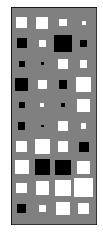

In [11]:
#cov_factor = torch.cat([true_variables['cov_factor_0'], torch.unsqueeze(true_variables['cov_factor_new_0'], dim=-2)], dim=-2)
hinton(true_variables['cov_factor_0'].detach())

In [12]:
data, test_data = train_test_split(X)

In [13]:
seed = 8
#for seed in range(1,10):
pyro.set_rng_seed(seed)
ARD = ZeroMeanFactorARD(data, 16, '3')
inference_args = (ARD, data, test_data, config)
inference_results = inference(*inference_args)

....................

NLL after 20/1000 iterations is 25.31422996520996


.........

NLL after 30/1000 iterations is 25.277751922607422


.........

NLL after 40/1000 iterations is 25.080883026123047


.........

NLL after 50/1000 iterations is 24.91507339477539


.........

NLL after 60/1000 iterations is 24.60361671447754


.........

NLL after 70/1000 iterations is 24.457473754882812


.........

NLL after 80/1000 iterations is 24.33786392211914


.........

NLL after 90/1000 iterations is 24.31064224243164


.........

NLL after 100/1000 iterations is 24.16607093811035


.........

NLL after 110/1000 iterations is 24.01435089111328


.........

NLL after 120/1000 iterations is 23.93276596069336


.........

NLL after 130/1000 iterations is 23.914806365966797


.........

NLL after 140/1000 iterations is 23.84493637084961


.........

NLL after 150/1000 iterations is 23.861738204956055


.........

NLL after 160/1000 iterations is 23.88505744934082


.........

NLL after 170/1000 it

In [14]:
inference_results.keys()

dict_keys(['gradient_norms', 'loss', 'MNLL', 'training_duration', 'param_history', 'optimizer_state', 'param_store_state'])

(-5, 6)

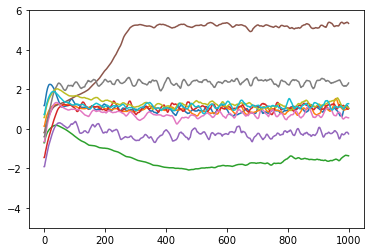

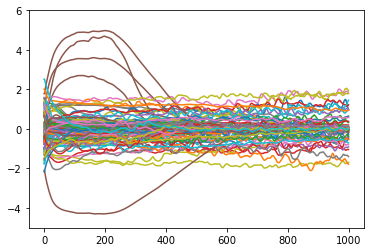

In [15]:
plt.plot(inference_results['param_history']['cov_diag_loc_3'].detach());
plt.ylim(-5,6)
plt.figure()
plt.plot(inference_results['param_history']['cov_factor_loc_3'].reshape(-1,D*D).detach());
plt.ylim(-5,6)

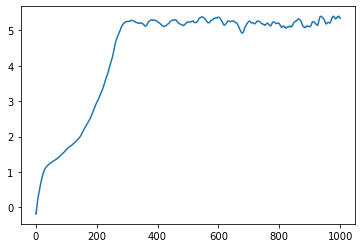

In [16]:
plt.plot(inference_results['param_history']['cov_diag_loc_3'][:,5].detach())

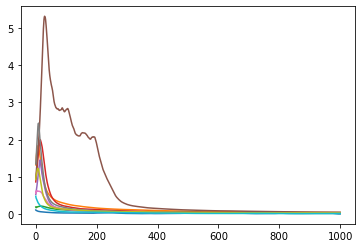

In [17]:
plt.plot(inference_results['param_history']['cov_diag_scale_3'].detach())

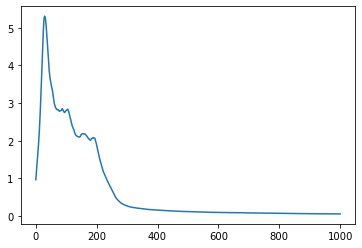

In [18]:
plt.plot(inference_results['param_history']['cov_diag_scale_3'][:,5].detach())

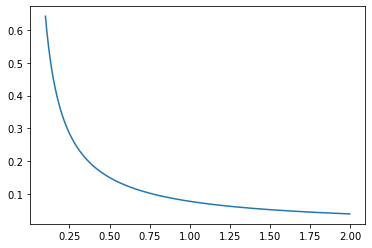

In [19]:
plt.plot(torch.arange(0.1,2,0.001).float(),torch.exp(dist.LogNormal(1.,5.).log_prob(torch.arange(0.1,2,0.001).float())))

In [20]:
0.00000001

1e-08

In [21]:
dist.LogNormal(1.,5.).log_prob(torch.tensor(1e-08))-dist.LogNormal(1.,5.).log_prob(torch.tensor(1e-08))

tensor(0.)

In [22]:
torch.exp(torch.tensor(8.3490))

tensor(4225.9526)

<Figure size 432x288 with 0 Axes>

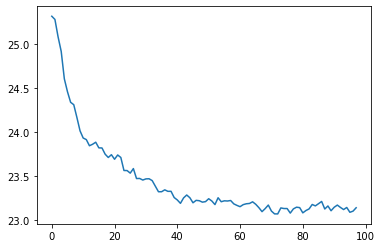

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(inference_results['MNLL'])
plt.figure()

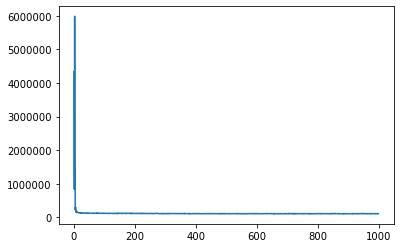

In [24]:
plt.plot(inference_results['loss'])

In [25]:
ARD.sample_posterior_predictive(ARD.N)

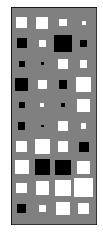

In [44]:
hinton(true_variables['cov_factor_0'].detach())

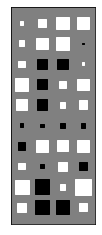

In [49]:
hinton(torch.matmul(true_variables['cov_factor_0'],ARD.posterior_samples['cov_factor_3'].mean(0).squeeze()).detach())

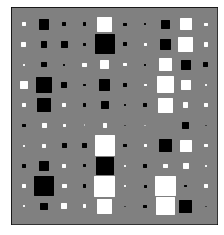

In [26]:
hinton(ARD.posterior_samples['cov_factor_3'].mean(0).squeeze().detach())

(0, 5)

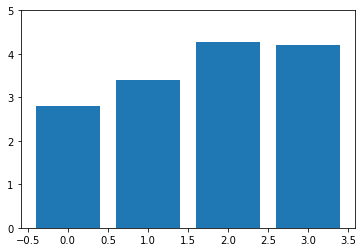

In [42]:
plt.bar(np.arange(K),true_variables['cov_factor_0'].detach().norm(dim=-1))
plt.ylim(0,5)

(0, 5)

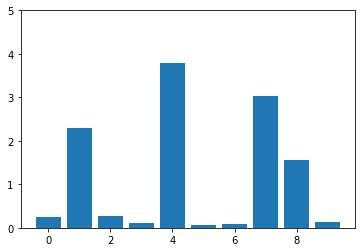

In [43]:
plt.bar(np.arange(D),ARD.posterior_samples['cov_factor_3'].mean(0).squeeze().norm(dim=-1).detach())
plt.ylim(0,5)

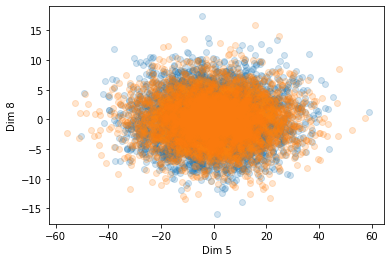

In [51]:
random_dims = np.random.choice(D, size=2)
plt.scatter(*X[:,random_dims].T,alpha=.2)
plt.scatter(*ARD.posterior_predictive_samples[:,random_dims].T,alpha=.2)
plt.xlabel(f'Dim {random_dims[0]}')
plt.ylabel(f'Dim {random_dims[1]}');